In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import warnings
warnings.filterwarnings('ignore')
clean_df = pd.read_csv("/content/drive/MyDrive/data/clean_data.csv")
clean_df.set_index('Store',inplace=True)
clean_df = clean_df.sample(10000)
clean_df.shape

(10000, 21)

In [4]:
scaler = MinMaxScaler()

In [5]:
scaler.fit(clean_df.Sales.values.reshape([-1, 1]))
clean_df['trainSalesScaled'] = scaler.transform(clean_df.Sales.values.reshape(-1, 1))
clean_df.tail(10)

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,SalePerCustomer,Year,Month,Day,Week,Season,CompetitionDistanceLOG,trainSalesScaled
Store,,,,,,,,,,,,,,,,,,,,,,
75,6,2015-07-11,6196,705,1,0,0,0,d,c,22440.0,12,2013,0,8.788652,2015,7,11,0,Summer,10.018600,0.149118
503,2,2013-07-16,6721,450,1,1,0,1,d,c,13080.0,9,2006,1,14.935556,2013,7,16,1,Summer,9.478840,0.161753
590,1,2014-10-20,5550,411,1,1,0,0,d,c,4520.0,9,2010,1,13.503650,2014,10,20,3,Fall,8.416267,0.133571
951,5,2015-01-02,6400,607,1,0,0,1,d,c,710.0,1,2013,1,10.543657,2015,1,2,1,Winter,6.565265,0.154028
1096,6,2013-12-28,5023,600,1,0,0,0,a,c,1130.0,1,2013,1,8.371667,2013,12,28,0,Winter,7.029973,0.120888
477,6,2014-02-08,5759,430,1,0,0,0,d,a,770.0,7,2010,1,13.393023,2014,2,8,2,Winter,6.646391,0.138601
824,1,2013-05-06,5454,761,1,0,0,0,a,a,17570.0,1,2013,0,7.166886,2013,5,6,3,Summer,9.773948,0.131260
855,4,2015-01-15,6441,626,1,1,0,0,a,a,3440.0,1,2013,1,10.289137,2015,1,15,3,Winter,8.143227,0.155014
1025,5,2015-06-05,10028,1091,1,1,0,0,a,a,720.0,11,2009,0,9.191567,2015,6,5,3,Summer,6.579251,0.241342


In [6]:
clean_df.sort_values(by=['Date'], inplace=True)

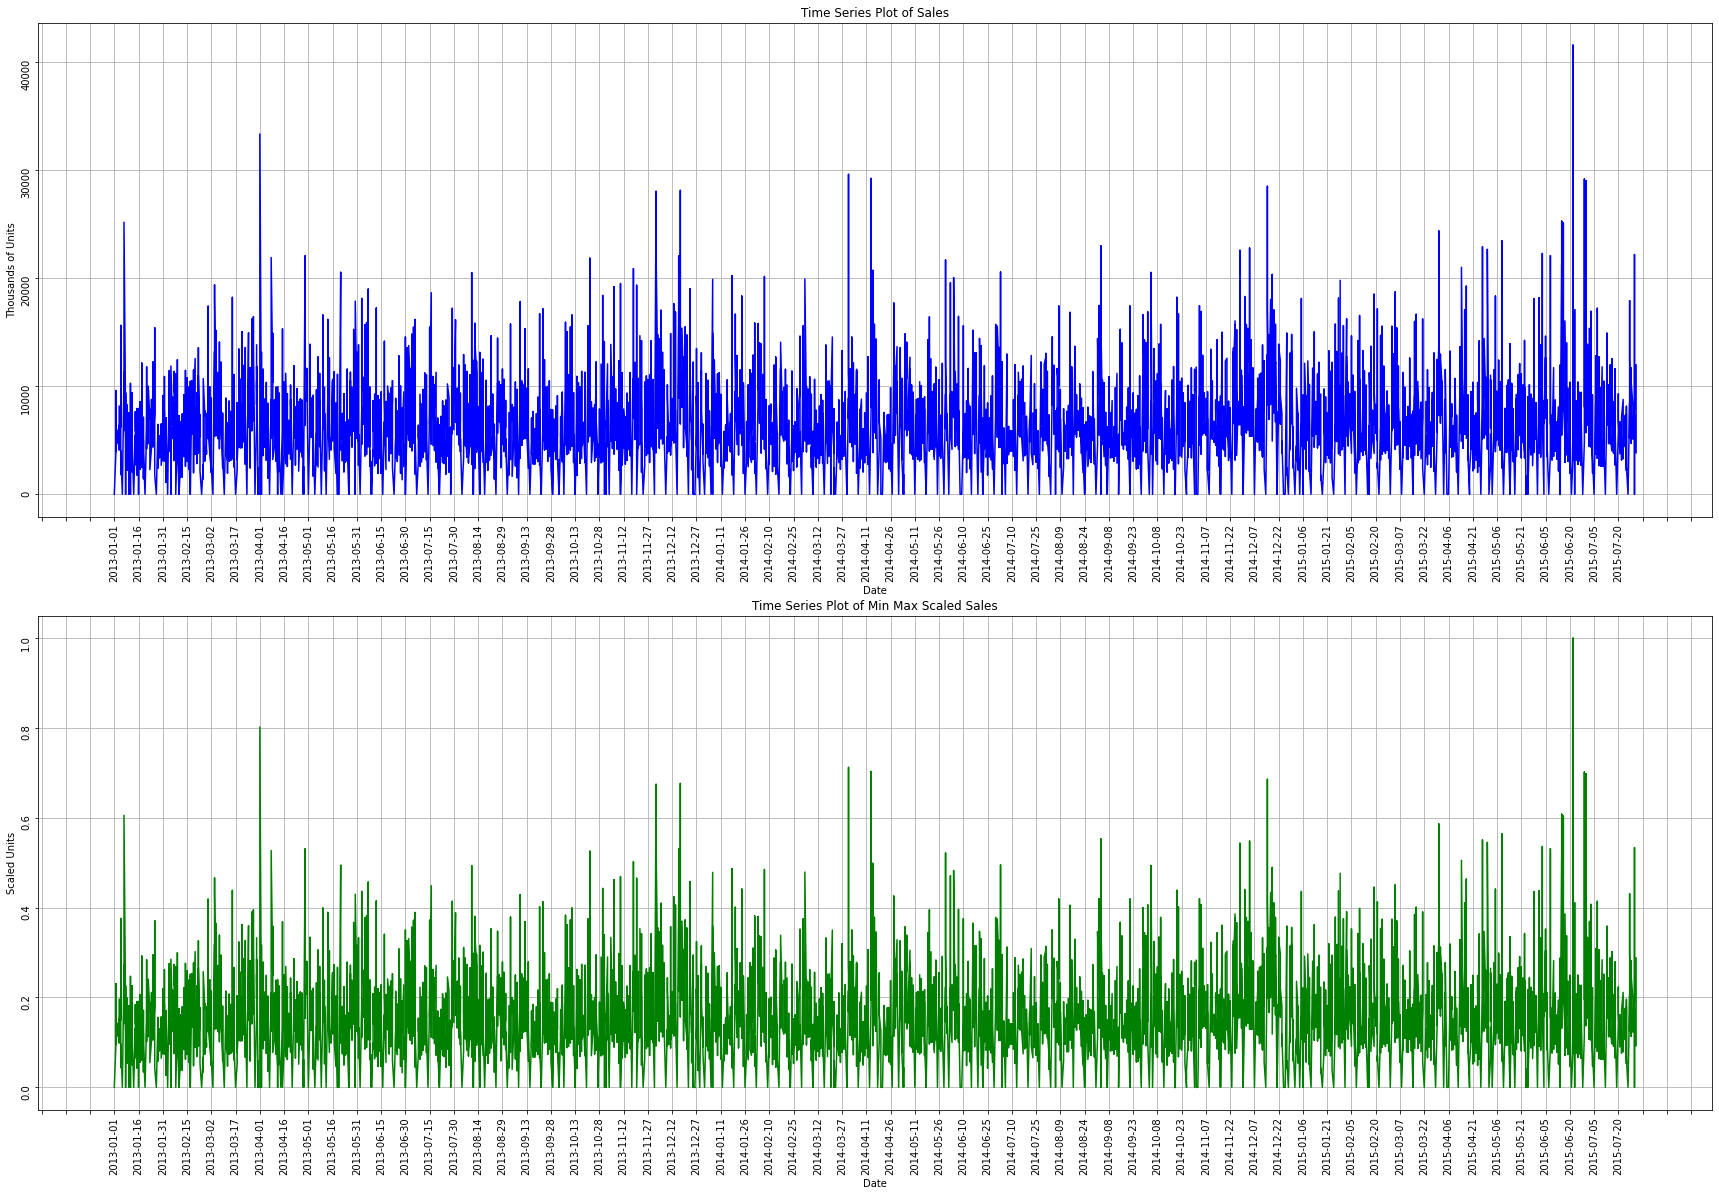

In [7]:
plt.rcParams['agg.path.chunksize'] = 1000
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(clean_df.Date, clean_df.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(clean_df.Date, clean_df.trainSalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Sales')
ax2.grid(True)
plt.show()

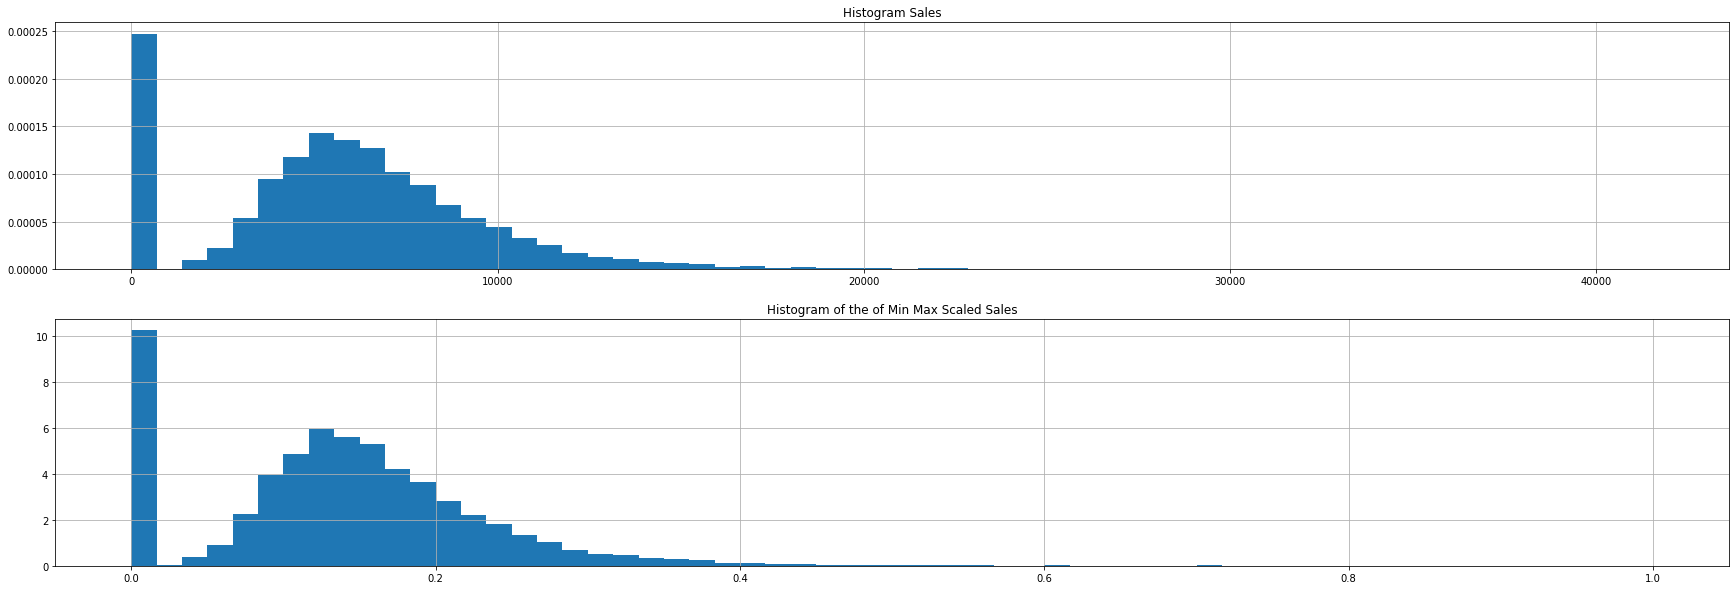

In [8]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(clean_df.Sales, density=True, bins=60)
ax1.title.set_text('Histogram Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(clean_df.trainSalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled Sales')
ax2.grid(True)
plt.show()

In [9]:
adfResult = adfuller(clean_df.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -24.60679680864032
p-value: 0.0


In [10]:
adfResult = adfuller(clean_df.trainSalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -24.60679680864026
p-value: 0.0


In [11]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [12]:
clean_dfSalesDif = difference(clean_df.trainSalesScaled.values)

In [13]:
clean_dfSalesDif

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
9994   -0.110082
9995    0.138192
9996   -0.080407
9997    0.010180
9998    0.123896
Length: 9999, dtype: float64

In [14]:
acfSalesScaled = acf(clean_df.trainSalesScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [15]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of House Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

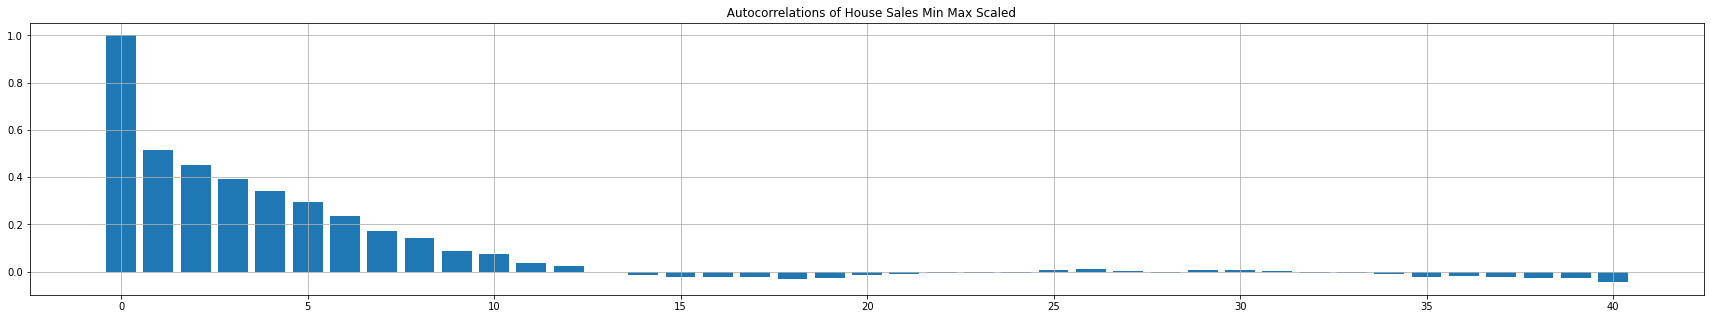

In [16]:
corrPlots(acfSalesScaledNp, '')

In [17]:
pacfSalesScaled = pacf(clean_df.trainSalesScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

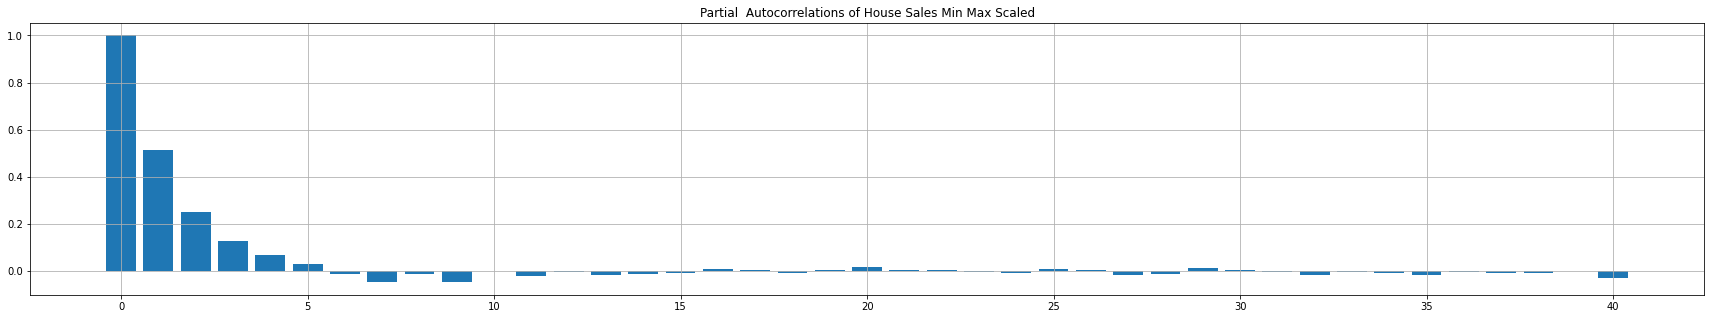

In [18]:
corrPlots(pacfSalesScaledNp, "Partial")

In [19]:
SIZE = len(clean_df.trainSalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [20]:
DateTrain = clean_df.Date.values[0:BATCH_SIZE]
DateValid = clean_df.Date.values[BATCH_SIZE:]
XTrain = clean_df.trainSalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = clean_df.trainSalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (9904, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (9904,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [21]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([9904, 1])

In [22]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset shapes: (1,), types: tf.float32>

In [23]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [24]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [25]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [26]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [27]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [28]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [29]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [30]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 8)           320       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 7s 7s/step - loss: 0.0215 - val_loss: 0.0353
Epoch 2/200
1/1 [==============================] - 2s 2s/step - loss: 0.0202 - val_loss: 0.0335
Epoch 3/200
1/1 [==============================] - 2s 2s/step - loss: 0.0190 - val_loss: 0.0317
Epoch 4/200
1/1 [==============================] - 2s 2s/step - loss: 0.0178 - val_loss: 0.0300
Epoch 5/200
1/1 [==============================] - 2s 2s/step - loss: 0.0167 - val_loss: 0.0284
Epoch 6/200
1/1 [==============================] - 2s 2s/step - loss: 0.0157 - val_loss: 0.0268
Epoch 7/200
1/1 [==============================] - 2s 2s/step - loss: 0.0147 - val_loss: 0.0253
Epoch 8/200
1/1 [==============================] - 2s 2s/step - loss: 0.0137 - val_loss: 0.0239
Epoch 9/200
1/1 [==============================] - 2s 2s/step - loss: 0.0129 - val_loss: 0.0225
Epoch 10/200
1/1 [==============================] - 2s 2s/step - loss: 0.0120 - val_loss: 0.0212
Epoch 11/200
1/1 [=====================

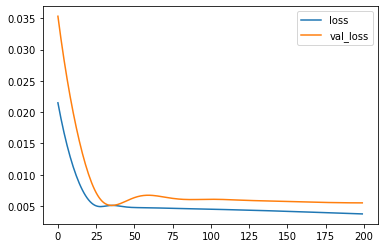

In [33]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [34]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [35]:
Forecast = model_forecast(model, clean_df.trainSalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

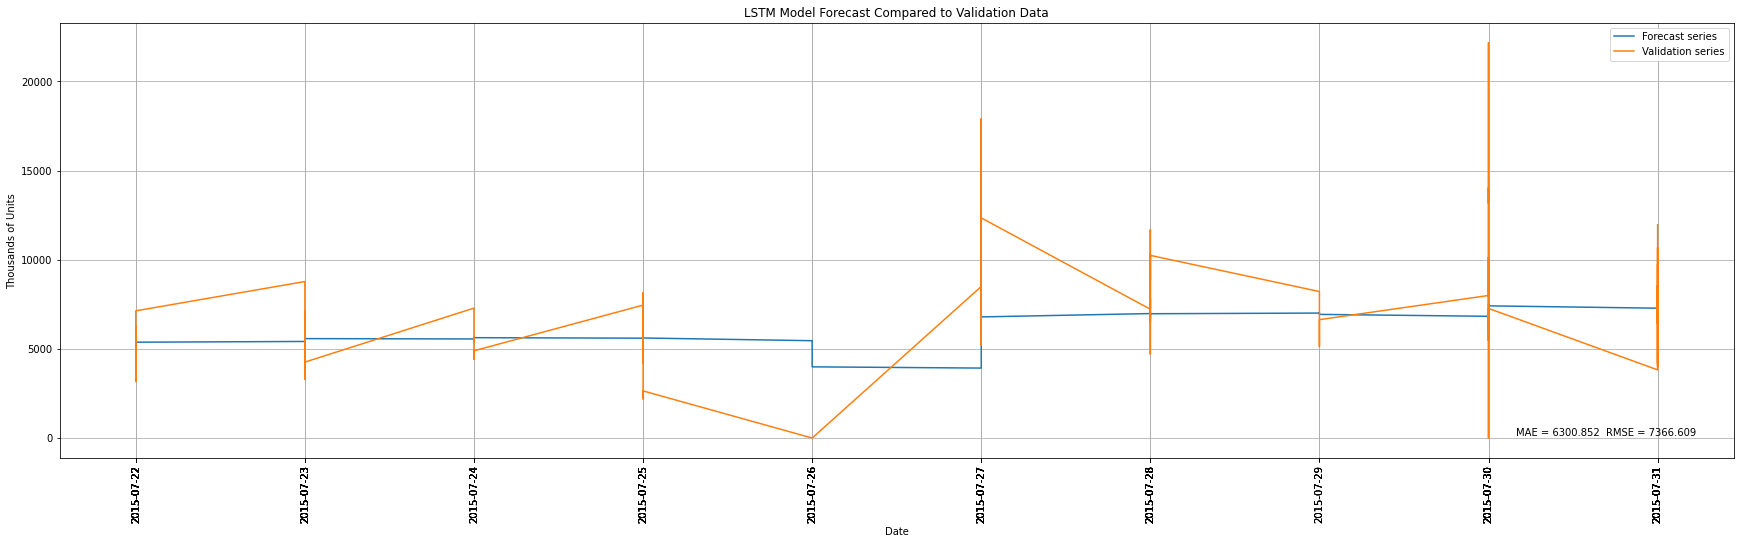

In [36]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [37]:
print(textstr)

MAE = 6300.852  RMSE = 7366.609
